In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from torch.utils.data import random_split

In [17]:
# !gdown --id 1HB5zM6WYnussodxj2L5BSpX6c2HhkhJe #1HsvAl5WqvqXFJOnjwabZTmkSY3JrVzBa
# !unzip dataset128.zip
!unzip test_data.zip 


Archive:  test_data.zip
caution: filename not matched:  -y


In [3]:
# !pip3 install pytorch_lightning
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer

In [40]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
from torchvision import transforms as T
from random import random, choice

# For .npz data    
class CustomData(Dataset):

  def __init__(self, dir, mode):
    self.mode = mode
    self.dir = dir
    self.scans = sorted([x for x in os.listdir(self.dir + 'scans') if x[-3:]=='npz'])
    self.strs = sorted(os.listdir(self.dir + 'structures'))
    # self.struc_3d = sorted([x for x in os.listdir(self.dir + '3d_structures') if x[-3:]=='npz'])
    self.len = len(self.scans)


  @staticmethod
  def transform(scan, structure, structure_3d):
  
    # Horizontal flip
    if random()>0.5:
      scan = T.functional.hflip(scan)
      structure = T.functional.hflip(structure)
      # structure_3d = T.functional.hflip(structure_3d)

    
    #Vertical flip
    if random()>0.5:
      scan = T.functional.vflip(scan)
      structure = T.functional.vflip(structure)
      # structure_3d = T.functional.vflip(structure_3d)

  
    #Rotation
    if random()>0.5:
      rand_deg = choice([90, -90])
      scan = T.functional.rotate(scan, angle = rand_deg)
      structure = T.functional.rotate(structure, angle = rand_deg)
      # structure_3d = T.functional.rotate(structure_3d, angle = rand_deg)
    
    return scan, structure

  def __len__(self):
    self.border = int(self.len * 0.8)
    if self.mode == 'train':
      return self.border
    elif self.mode == 'test':
      return int(self.len * 0.2)

  def __getitem__(self, idx):
    if self.mode == 'train':
      image = torch.from_numpy(np.load(self.dir + 'scans/' + self.scans[idx]))
      image = torch.permute(image, (2, 0, 1)).float()
      structure = torch.from_numpy(np.array([a.T for a in np.load(self.dir + 'structures/' + self.strs[idx])])).float()
      # structure_3d = torch.from_numpy(np.array([a.T for a in np.load(self.dir + '3d_structures/' + self.struc_3d[idx])['arr_0']])).float()
      image, label= self.transform(scan=image, structure=structure)
      return image, label

    elif self.mode == 'test':
      image = torch.from_numpy(np.load(self.dir + 'scans/' + self.scans[idx+self.border]))
      image = torch.permute(image, (2, 0, 1)).float()
      structure = torch.from_numpy(np.array([a.T for a in np.load(self.dir + 'structures/' + self.strs[idx+self.border])])).float()
      # structure_3d = torch.from_numpy(np.array([a.T for a in np.load(self.dir + '3d_structures/' + self.struc_3d[idx+self.border])['arr_0']])).float()
      return image, structure
    

# Initialization (here PATH_TO_DATA is path to directory where scans and structures are located, e.g. '/content/drive/MyDrive/dataset0/', 'MODE' = 'test' or 'train'):
# loader = DataLoader(CustomData('dataset2/', '2d'), num_workers=2, batch_size=16, shuffle=True)

In [29]:
for x, y in loader:
  break

ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/carla/.local/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/carla/.local/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/carla/.local/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-28-9873f035cf83>", line 62, in __getitem__
    scan_idx = self.scans_indexes.index(idx)
ValueError: 160709 is not in list


TypeError: Invalid shape (128,) for image data

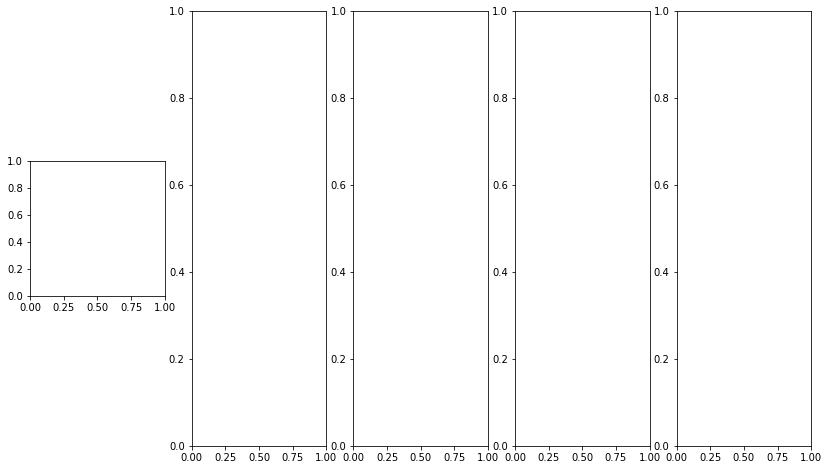

In [30]:
fig, axs = plt.subplots(1,5, figsize=(14,8))

axs[0].imshow(y[0,0].detach().numpy())
axs[1].imshow(y[0,1].detach().numpy())

axs[2].imshow(x[0,0].detach().numpy())
axs[3].imshow(x[0,10].detach().numpy())
axs[4].imshow(x[0,20].detach().numpy())

# axs[5].imshow(torch.mean(y_3d[::,0:5,::,::], dim=1)[0].detach().numpy())
# axs[6].imshow(torch.mean(y_3d[::,5:,::,::], dim=1)[0].detach().numpy())


axs[0].set_title('struc gold')
axs[1].set_title('struc alumin')

axs[2].set_title('scan 1')
axs[3].set_title('scan 10')
axs[4].set_title('scan 20')

# axs[5].set_title('3d struc mean 1')
# axs[6].set_title('3d struc mean 2')



plt.show()
# T.functional.vflip(x)

In [41]:
struct_dataset = CustomData('compare_data/test4k/', mode="test")
# train_set, val_set = torch.utils.data.random_split(struct_dataset, [len(struct_dataset)-200, 200])

In [8]:
# from UNet import UNet
# from enet import UNet as Unet
from stacked import Stacked
from stacked import StackedBaseline

In [9]:
BATCH_SIZE = 8
device = torch.device('cuda')

class SomeModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.model = Stacked(n_stacks=3).to(device)

    def forward(self, x):
        x.to(device)
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        pred = self(x)
        loss = sum([F.mse_loss(inter, y) for inter in pred])/3
        self.log("train_loss", loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        # loss = F.mse_loss(self(x), y)
        pred = self(x)
        loss = sum([F.mse_loss(inter, y) for inter in pred])/3
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        # return loss
        return {'MSE': loss, 'pred': pred[-1], 'mask': y}

    def validation_epoch_end(self, outputs):
        mse = torch.tensor([x['MSE'] for x in outputs])

        # mean_iou, mean_class_rec, mean_acc = loss.calc_val_loss(intersection, union, target, self.eps)
        # mean_iou, mean_class_rec, mean_acc = calc_val_loss(intersection, union, target, self.eps)
        mean_mse = torch.mean(mse)

        log_dict = {'mean_mse': mean_mse}

        for k, v in log_dict.items():
            self.log(k, v, prog_bar=True)

         # Visualize results
        # img = torch.cat([x['img'] for x in outputs]).cpu()
        pred_1 = torch.cat([x['pred'][0][0] for x in outputs]).unsqueeze(dim=0).cpu()
        pred_2 = torch.cat([x['pred'][0][1] for x in outputs]).unsqueeze(dim=0).cpu()

        mask_1 = torch.cat([x['mask'][0][0] for x in outputs]).unsqueeze(dim=0).cpu()
        mask_2 = torch.cat([x['mask'][0][1] for x in outputs]).unsqueeze(dim=0).cpu()


        # pred_vis = self.visualize_mask(torch.argmax(pred, dim=1))
        # mask_vis = self.visualize_mask(mask)
        results = torch.cat(torch.cat([pred_1, pred_2, mask_1, mask_2], dim=2).split(1, dim=0), dim=1)
        # results_thumbnail = F.interpolate(results, scale_factor=0.25, mode='bilinear')[0]

        self.logger.experiment.add_image('results', results, self.current_epoch)
    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)
    
    
    def setup(self, stage=None):
        
        self.train_set, self.test_set, self.val_set = random_split(struct_dataset, [len(struct_dataset)-200, 100, 100])
        
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            pass
        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            pass
    
    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=BATCH_SIZE, num_workers=8)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=BATCH_SIZE, num_workers=8)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=BATCH_SIZE, num_workers=8)
    

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [ ]:
import tensorboard

In [12]:
# Init our model
some_model = SomeModel().to(device)
logger = pl.loggers.TensorBoardLogger(save_dir=f'logs', name="archive_stacked_4_3_mean")

# Initialize a trainer
trainer = Trainer(
    devices=[0], 
    accelerator="gpu",
    max_epochs=10,
    progress_bar_refresh_rate=1,
    logger=logger
)

# Train the model ⚡
trainer.fit(some_model)

/home/carla/.local/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | Stacked | 75.2 M
----------------------------------
75.2 M    Trainable params
0         Non-trainable params
75.2 M    Total params
300.800   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [10]:
def define_model(lr: float, 
                 checkpoint_name: str = '', 
                 batch_size: int = 16):
    assignment_dir = 'stacked_res'
    experiment_name = f'Exp1'
    
    model = SomeModel()

    if checkpoint_name:
        model.load_state_dict(torch.load(f'logs/archive_stacked_4_3_mean_100/version_0/checkpoints/epoch=99-step=127499.ckpt')['state_dict'])
    
    return model, experiment_name

model, _ = define_model(lr= 1, checkpoint_name="yes")

In [53]:
import os

val_pics = sorted(os.listdir('compare_data/test4k/scans')) # путь до сканов
val_strs = sorted(os.listdir('compare_data/test4k/struct')) # путь до структур

def pic_saver(pred, gt, name):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes[0][0].imshow(pred[0].detach().cpu().numpy(), interpolation='nearest', origin='lower', vmin=0, vmax=15)
    axes[0][0].set_title('Prediction for Au layer')
    axes[0][1].imshow(gt[0].detach().cpu().numpy(), interpolation='nearest', origin='lower', vmin=0, vmax=15)
    axes[0][1].set_title('Ground truth for Au layer')

    axes[1][0].imshow(pred[1].detach().cpu().numpy(), interpolation='nearest', origin='lower', vmin=0, vmax=150)
    axes[1][0].set_title('Prediction for Al layer')
    axes[1][1].imshow(gt[1].detach().cpu().numpy(), interpolation='nearest', origin='lower', vmin=0, vmax=150)
    axes[1][1].set_title('Ground truth for Al layer')

    fig.colorbar(axes[0][1].imshow(gt[0].T.detach().cpu().numpy(), interpolation='nearest', origin='lower', vmin=0, vmax=15), ax=axes[0], fraction=0.0213)
    fig.colorbar(axes[1][1].imshow(gt[1].T.detach().cpu().numpy(), interpolation='nearest', origin='lower', vmin=0, vmax=150), ax=axes[1], fraction=0.0213)
    
    fig.savefig('val_pics/'+name+'.png')
    plt.close(fig)
    
#  ! mkdir val_pics
model.cuda()
for pic, struct in zip(val_pics, val_strs):
    scan = np.load('compare_data/test4k/scans/' + pic)
    scan = torch.unsqueeze(torch.permute(torch.from_numpy(scan), (2, 0, 1)), dim=0).float()
    pred = torch.squeeze(model(scan.cuda())[-1])
    pred[0]*=15
    pred[1]*=150
    gt = torch.from_numpy(np.load('compare_data/test4k/struct/' + struct))
    pic_saver(pred, gt, pic[5:-4])
    np.save('val_pics/'+pic[5:-4]+'.npy', pred.detach().cpu())
    
#  ! zip val_pics val_pics/*

/home/carla/.local/lib/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


AttributeError: 

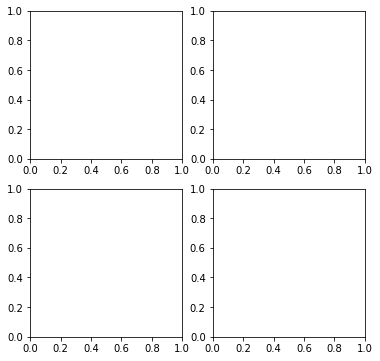

In [42]:
from numpy.core.fromnumeric import amax
fig, axs = plt.subplots(2,2, figsize=(6,6))


x, y = struct_dataset[0]

val_model = model.to('cpu')

with torch.no_grad():
    res = val_model(torch.unsqueeze(x,0))[-1][0]
    # print(res[0].shape)
    # res = res[-1][0]
    first_pred, second_pred = res[0], res[1]
    
axs[1,0].imshow(np.array(first_pred))
axs[1,1].imshow(np.array(second_pred))

axs[0,0].imshow(np.array(y[0]))#, vmin=0, vmax=1)
axs[0,1].imshow(np.array(y[1]))#, vmin=0, vmax=1)


axs[0,0].set_title('true gold')
axs[0,1].set_title('true alumin')

axs[1,0].set_title('predict gold')
axs[1,1].set_title('predict alumin')

for i in range(2):
  for j in range(2):
    axs[i,j].set_xticks([]) 
    axs[i,j].set_yticks([]) 


plt.show()
    